## Setup

### Loading and imports

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
import statsmodels.api as sm

from matplotlib.pyplot import subplots
from sklearn import preprocessing
from sklearn import utils
from sklearn.linear_model import LassoLarsCV, LassoCV, ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, auc
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import RFE
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

In [4]:
carseat_data = load_data("Carseats")
carseat_data

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


### Cleaning data

In [6]:
carseat_data['Urban_Yes'] = pd.Series(np.zeros(carseat_data.shape[0]))
carseat_data.loc[carseat_data['Urban']=='Yes', 'Urban_Yes'] = 1

carseat_data['US_Domestic'] = pd.Series(np.zeros(carseat_data.shape[0]))
carseat_data.loc[carseat_data['US']=='Yes', 'US_Domestic'] = 1

carseat_data['ShelveLoc_rank'] = pd.Series(np.zeros(carseat_data.shape[0]))
carseat_data.loc[carseat_data['ShelveLoc']=='Bad', 'ShelveLoc_rank'] = -1
carseat_data.loc[carseat_data['ShelveLoc']=='Good', 'ShelveLoc_rank'] = 1

carseat = carseat_data.drop(["US", "Urban", "ShelveLoc"], axis=1) # carseat will now be the cleaned version of carseat_data

carseat

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban_Yes,US_Domestic,ShelveLoc_rank
0,9.50,138,73,11,276,120,42,17,1.0,1.0,-1.0
1,11.22,111,48,16,260,83,65,10,1.0,1.0,1.0
2,10.06,113,35,10,269,80,59,12,1.0,1.0,0.0
3,7.40,117,100,4,466,97,55,14,1.0,1.0,0.0
4,4.15,141,64,3,340,128,38,13,1.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,33,14,1.0,1.0,1.0
396,6.14,139,23,3,37,120,55,11,0.0,1.0,0.0
397,7.41,162,26,12,368,159,40,18,1.0,1.0,0.0
398,5.94,100,79,7,284,95,50,12,1.0,1.0,-1.0


## Model building

### Model Setup

In [9]:
carseat_x = carseat.drop(["Sales"], axis=1)
carseat_x['intercept'] = np.ones(carseat.shape[0])
carseat_y = carseat["Sales"]

x_train, x_test, y_train, y_test = train_test_split(carseat_x, carseat_y, test_size = 0.3, shuffle=True, random_state=42)

train = pd.merge_ordered(x_train,y_train,left_on=x_train.index,right_on=y_train.index).drop(columns=['key_0'])
test = pd.merge_ordered(x_test,y_test,left_on=x_test.index,right_on=y_test.index).drop(columns=['key_0'])

C:\Users\adam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

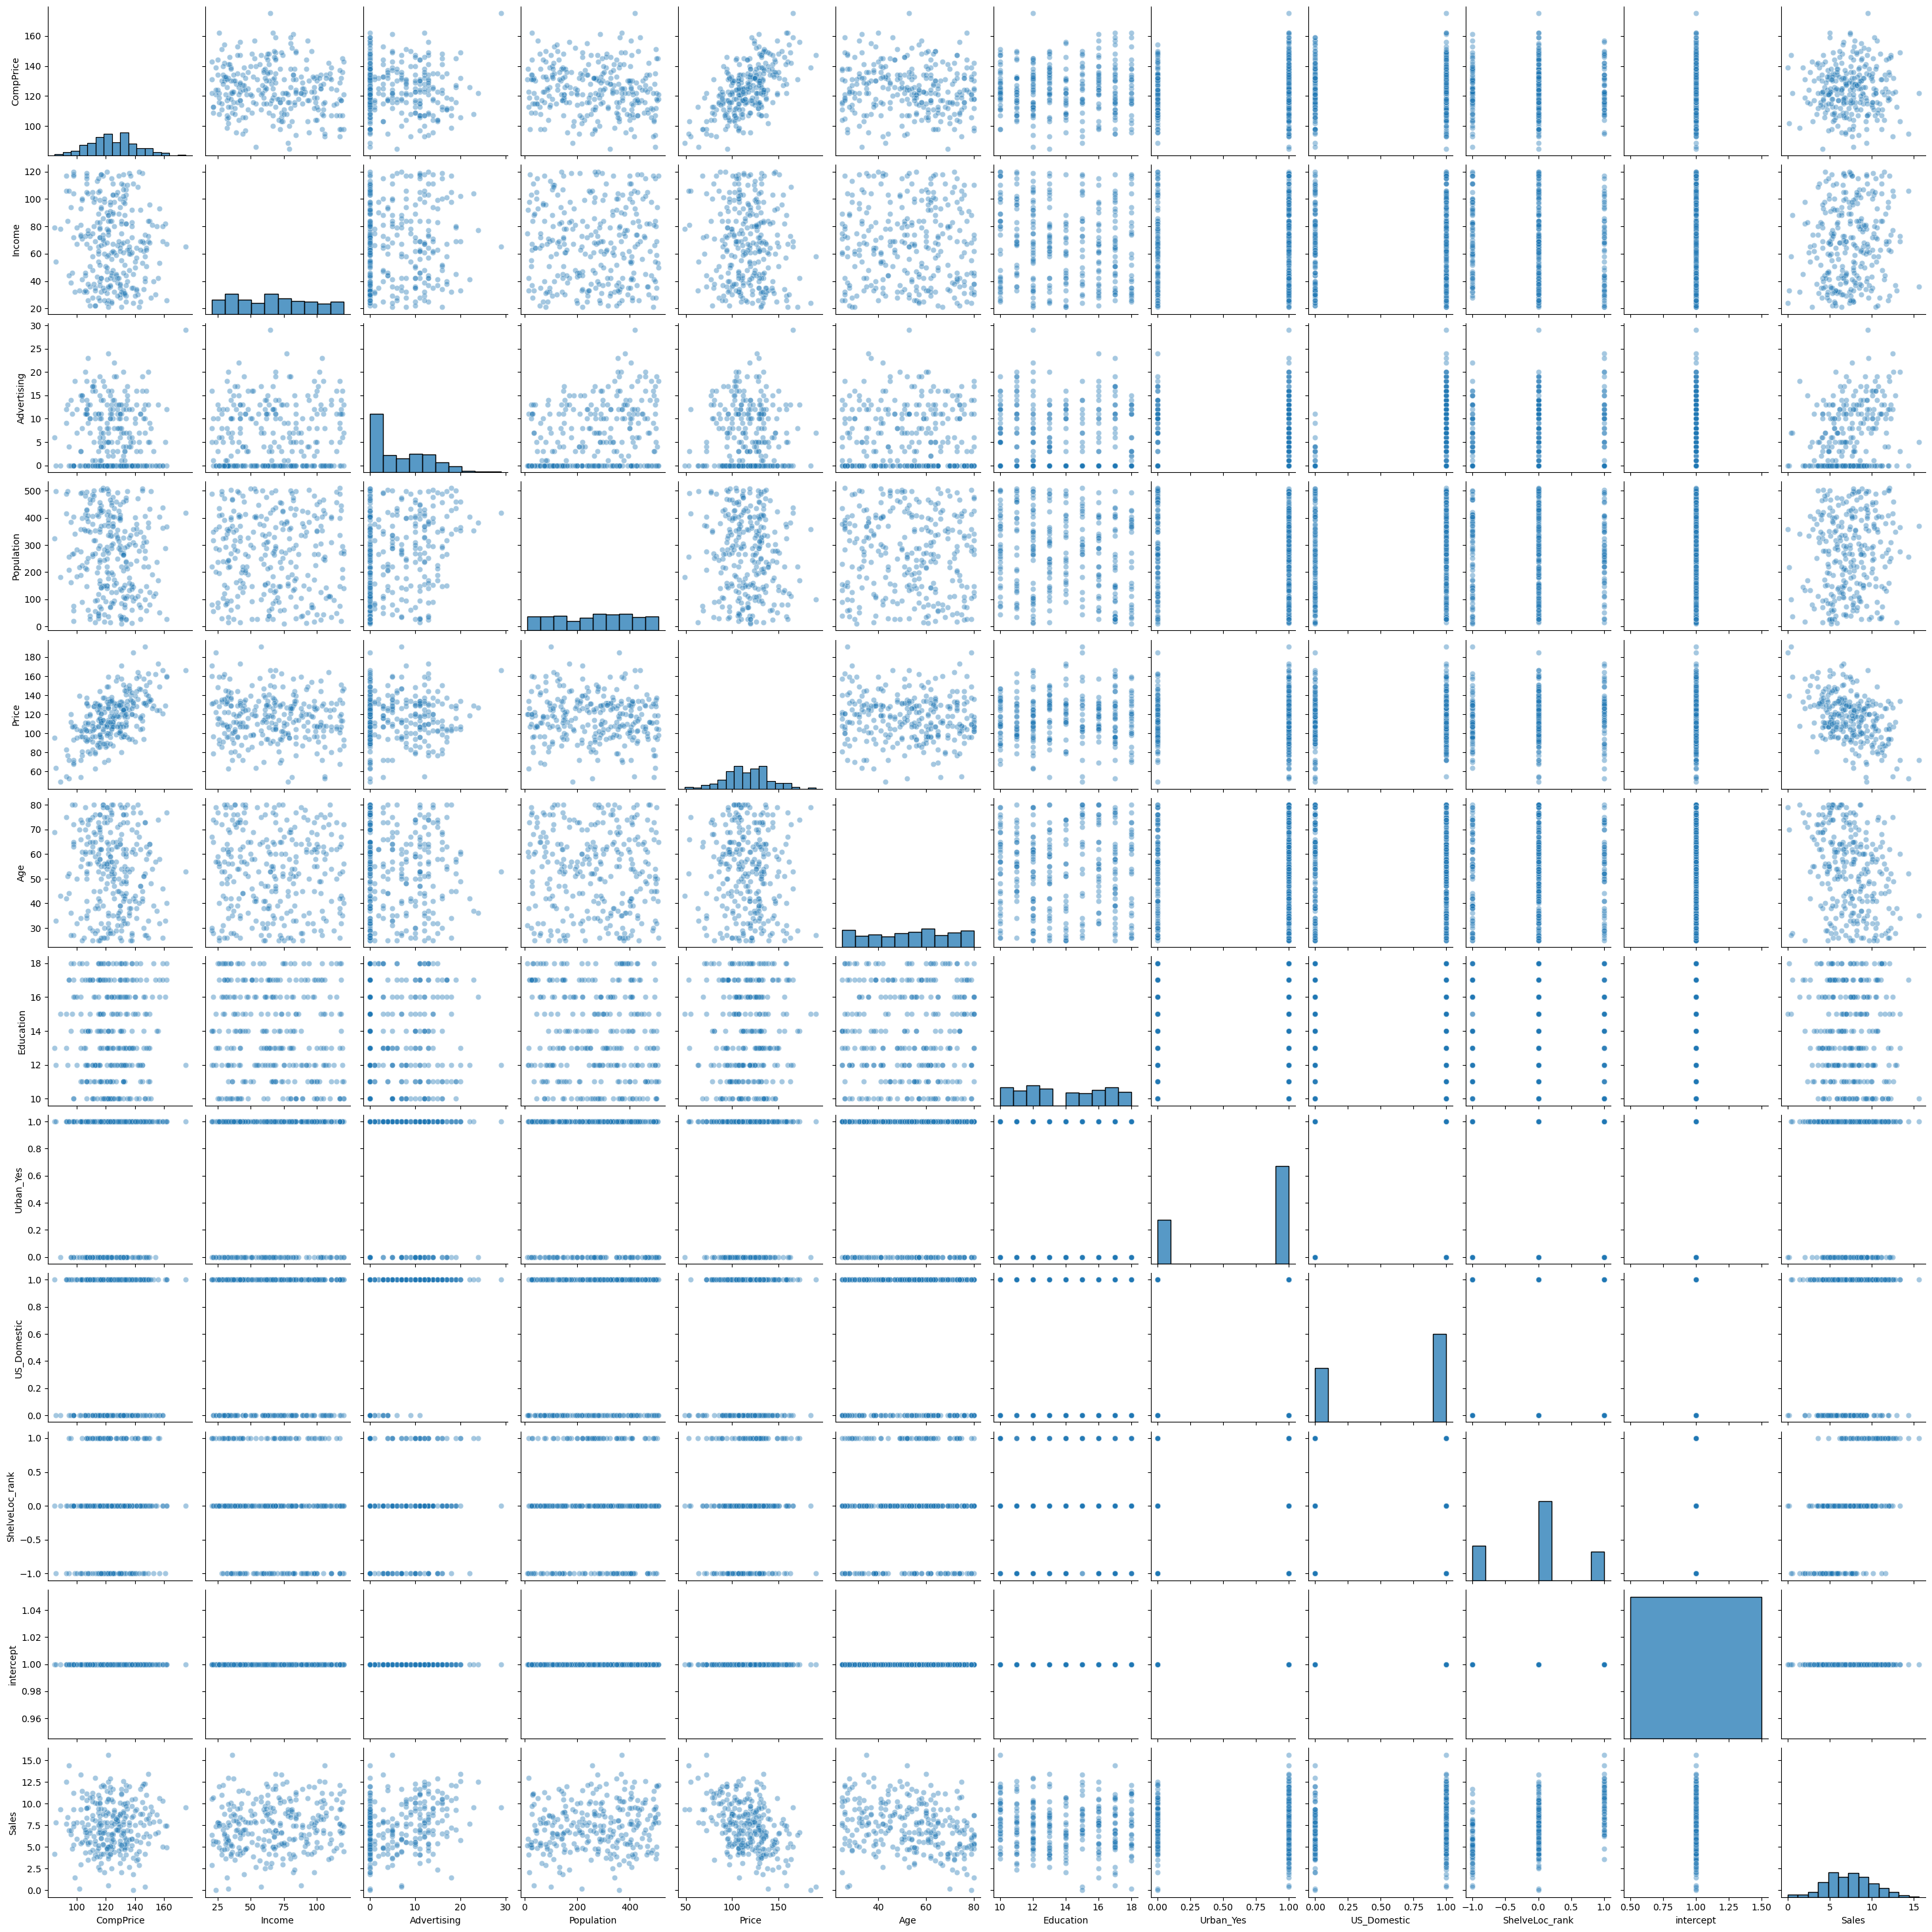

In [10]:
sns.pairplot(train, kind='scatter', plot_kws={'alpha':0.4}) #box plot to take a better look at the data

In [11]:
train.corr()

,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban_Yes,US_Domestic,ShelveLoc_rank,intercept,Sales
CompPrice,1.000000,-0.116735,-0.034363,-0.119979,0.613373,-0.091795,0.033220,0.098746,0.006723,0.005767,NaN,0.015932
Income,-0.116735,1.000000,0.064397,-0.015310,-0.098704,-0.035479,-0.116830,0.048759,0.060138,-0.119741,NaN,0.123410
Advertising,-0.034363,0.064397,1.000000,0.277709,0.030414,-0.018299,-0.090074,0.031409,0.706534,0.086553,NaN,0.290045
Population,-0.119979,-0.015310,0.277709,1.000000,-0.085565,-0.046842,-0.146943,-0.052006,0.101432,0.018420,NaN,0.130473
Price,0.613373,-0.098704,0.030414,-0.085565,1.000000,-0.059137,0.034548,0.048860,0.060615,0.084375,NaN,-0.456355
Age,-0.091795,-0.035479,-0.018299,-0.046842,-0.059137,1.000000,0.002502,0.030635,-0.031135,0.024673,NaN,-0.278510
Education,0.033220,-0.116830,-0.090074,-0.146943,0.034548,0.002502,1.000000,-0.078539,-0.114232,-0.014130,NaN,-0.086106
Urban_Yes,0.098746,0.048759,0.031409,-0.052006,0.048860,0.030635,-0.078539,1.000000,0.080577,-0.101432,NaN,-0.018785
US_Domestic,0.006723,0.060138,0.706534,0.101432,0.060615,-0.031135,-0.114232,0.080577,1.000000,0.027244,NaN,0.155128
ShelveLoc_rank,0.005767,-0.119741,0.086553,0.018420,0.084375,0.024673,-0.014130,-0.101432,0.027244,1.000000,NaN,0.514730


### Getting a baseline

In [13]:
# getting a baseline model to look at since were going to reverse selection 
baseline = sm.OLS(y_train, x_train)
results = baseline.fit()
summarize(results)

,coef,std err,t,P>|t|
CompPrice,0.0928,0.005,18.629,0.000
Income,0.0139,0.002,6.308,0.000
Advertising,0.1243,0.014,8.850,0.000
Population,0.0004,0.000,0.933,0.352
Price,-0.0974,0.003,-29.759,0.000
Age,-0.0479,0.004,-12.817,0.000
Education,-0.0240,0.024,-1.003,0.317
Urban_Yes,0.1480,0.134,1.102,0.272
US_Domestic,-0.2436,0.181,-1.347,0.179
ShelveLoc_rank,2.4357,0.094,25.939,0.000


In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     179.5
Date:                Sat, 06 Jul 2024   Prob (F-statistic):          7.90e-113
Time:                        18:30:50   Log-Likelihood:                -397.16
No. Observations:                 280   AIC:                             816.3
Df Residuals:                     269   BIC:                             856.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
CompPrice          0.0928      0.005     18.629      0.000       0.083       0.103
Income             0.0139      0.002      6.308      0.000       0.010       0.018
Advertising        0.1243      0.014      8.850      0.000       0.097       0.152
Population         0.0004      0.000      0.933      0.352      -0.000       0.001
Price             -0.0974      0.003    -29.759      0.000      -0.104      -0.091
Age               -0.0479      0.004    -12.817      0.000      -0.055      -0.041
Education         -0.0240      0.024     -1.003      0.317      -0.071       0.023
Urban_Yes          0.1480      0.134      1.102      0.272      -0.116       0.412
US_Domestic       -0.2436      0.181     -1.347      0.179      -0.600       0.113
ShelveLoc_rank     2.4357      0.094     25.939      0.000       2.251       2.621
intercept          8.3143      0.723     11.497      0.000       6.890       9.738
==============================================================================
Omnibus:                        0.710   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.701   Jarque-Bera (JB):                0.495
Skew:                           0.085   Prob(JB):                        0.781
Kurtosis:                       3.118   Cond. No.                     4.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### recursive selection

In [16]:
def recursive_select(x_train, x_test, y_train, y_test, feature_num, selector, step=1): # fucntion to do recursive selection, returns the most important features and rfe score
    if feature_num >= x_train.shape[1]: return "Error, too many features for this set"
    x_train_c, x_test_c, y_train_c, y_test_c = x_train.copy(), x_test.copy(), y_train.copy(), y_test.copy()

    RFE_selector = RFE(estimator=selector, n_features_to_select=feature_num, step=step)
    RFE_selector = RFE_selector.fit(x_train_c, y_train_c)

    sel_x_train_c = RFE_selector.transform(x_train_c)
    sel_x_test_c = RFE_selector.transform(x_test_c)

    selector.fit(sel_x_train_c, y_train_c)
    RFE_preds = selector.predict(sel_x_test_c)
    
    rfe_r2_score = round(r2_score(y_test_c, RFE_preds),3)
    
    return((x_train_c.columns[RFE_selector.support_], rfe_r2_score))

def recursive_select_feature_set(x_train, x_test, y_train, y_test, selector, step=1):
    feature_range = list()
    for i in range(x_train.shape[1] - 1):
        feature_range.append(i + 1)

    results = list()
    for num in feature_range:
        results.append(recursive_select(x_train, x_test, y_train, y_test, num, selector, step))

    return results

In [17]:
lasso = LassoCV() # since our data is under 10,000 samples and only a few features should be important i had the chose between Lasso or ElasticNet,
                  # ill be trying a set with ElasticNet later since i dont know which one is more oppropriate with the data set
                  # i Used the regular Lasso selector over LassoLarsCV since according to the documentation "it is more fragile to heavily multicollinear datasets."
                  # and i dont know if the data is heavily multicollinear
recursive_select_feature_set(x_train, x_test, y_train, y_test, lasso, step=1)

[(Index(['ShelveLoc_rank'], dtype='object'), 0.374),
 (Index(['Advertising', 'ShelveLoc_rank'], dtype='object'), 0.423),
 (Index(['Advertising', 'Price', 'ShelveLoc_rank'], dtype='object'), 0.616),
 (Index(['CompPrice', 'Advertising', 'Price', 'ShelveLoc_rank'], dtype='object'),
  0.767),
 (Index(['CompPrice', 'Advertising', 'Price', 'Age', 'ShelveLoc_rank'], dtype='object'),
  0.82),
 (Index(['CompPrice', 'Advertising', 'Price', 'Age', 'Education',
         'ShelveLoc_rank'],
        dtype='object'),
  0.819),
 (Index(['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'Education',
         'ShelveLoc_rank'],
        dtype='object'),
  0.856),
 (Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
         'Education', 'ShelveLoc_rank'],
        dtype='object'),
  0.856),
 (Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
         'Education', 'ShelveLoc_rank', 'intercept'],
        dtype='object'),
  0.856),
 (Index(['CompPrice', 'In

In [18]:
# as we can see 7 features get us the highest r squared value before becoming redundent, lets use eleastic net next to see if it can give a better recurssive selection
elastic = ElasticNet()

recursive_select_feature_set(x_train, x_test, y_train, y_test, elastic, step=1)

[(Index(['ShelveLoc_rank'], dtype='object'), 0.107),
 (Index(['Advertising', 'ShelveLoc_rank'], dtype='object'), 0.152),
 (Index(['Advertising', 'Price', 'ShelveLoc_rank'], dtype='object'), 0.367),
 (Index(['CompPrice', 'Advertising', 'Price', 'ShelveLoc_rank'], dtype='object'),
  0.574),
 (Index(['CompPrice', 'Advertising', 'Price', 'Age', 'ShelveLoc_rank'], dtype='object'),
  0.626),
 (Index(['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'ShelveLoc_rank'], dtype='object'),
  0.663),
 (Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
         'ShelveLoc_rank'],
        dtype='object'),
  0.659),
 (Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
         'ShelveLoc_rank', 'intercept'],
        dtype='object'),
  0.659),
 (Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
         'US_Domestic', 'ShelveLoc_rank', 'intercept'],
        dtype='object'),
  0.659),
 (Index(['CompPrice', 'Income', 'Advertis

Our result with ElasticNet resulted in an R_squared value lower than the same sets of data in Lasso, im not really sure what to make of that. Either way ill be moving along with the 7 item elasticnet data set because big number better and its only diffrence from the lasso set being population and education, population has a higher correlation on our previous cahrt so thats how I decided between the two sets. Do note that they both start becoming redundant at 7 items so I think thats our key number.

### Moving on with the ElasticNet item choices

In [21]:
e_carseat_x = carseat[['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'Education','ShelveLoc_rank']]
e_carseat_x['intercept'] = np.ones(carseat.shape[0])

e_x_train, e_x_test, e_y_train, e_y_test = train_test_split(e_carseat_x, carseat_y, test_size = 0.3, shuffle=True, random_state=42)

C:\Users\adam\AppData\Local\Temp\ipykernel_37692\2381623466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_carseat_x['intercept'] = np.ones(carseat.shape[0])


In [22]:
e_model = sm.OLS(e_y_train, e_x_train[['intercept', 'CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'Education','ShelveLoc_rank']])
results = e_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     254.9
Date:                Sat, 06 Jul 2024   Prob (F-statistic):          1.56e-115
Time:                        18:30:52   Log-Likelihood:                -399.23
No. Observations:                 280   AIC:                             814.5
Df Residuals:                     272   BIC:                             843.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          8.5040      0.680     12.507      0.000       7.165       9.843
CompPrice          0.0929      0.005     18.735      0.000       0.083       0.103
Income             0.0138      0.002      6.278      0.000       0.010       0.018
Advertising        0.1144      0.010     11.945      0.000       0.096       0.133
Price             -0.0977      0.003    -29.838      0.000      -0.104      -0.091
Age               -0.0479      0.004    -12.809      0.000      -0.055      -0.040
Education         -0.0265      0.024     -1.126      0.261      -0.073       0.020
ShelveLoc_rank     2.4308      0.093     26.004      0.000       2.247       2.615
==============================================================================
Omnibus:                        0.717   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.699   Jarque-Bera (JB):                0.512
Skew:                           0.090   Prob(JB):                        0.774
Kurtosis:                       3.106   Cond. No.                     2.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see our R^2 value is high but also our eduaction P value is also high, i think its probably where any possible non linearity is but lets take a quick look at our fitted values

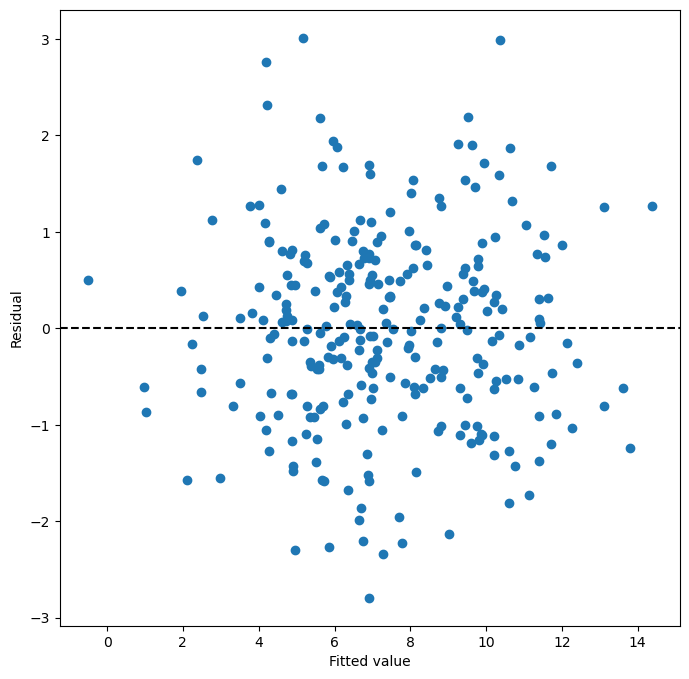

In [24]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

### Barlift Charts & analyzing our model

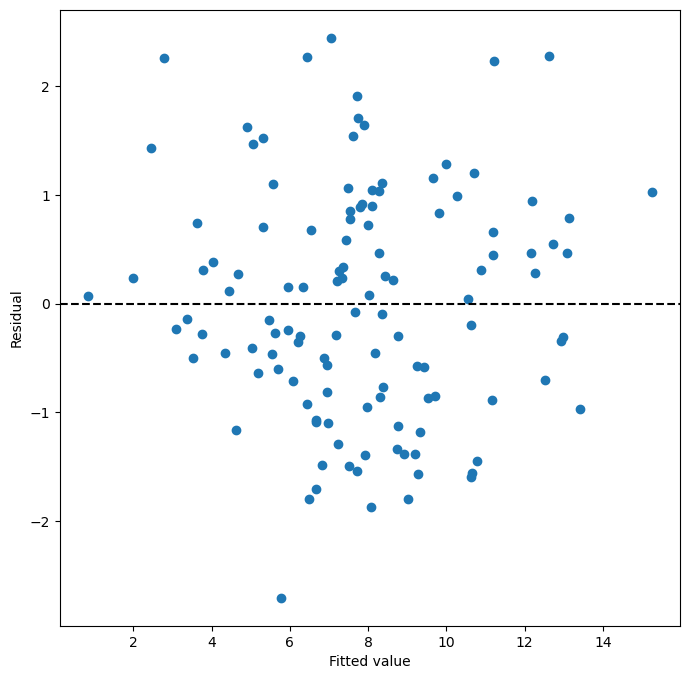

In [26]:
e_model_test = sm.OLS(e_y_test, e_x_test[['intercept', 'CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'Education','ShelveLoc_rank']])
results = e_model_test.fit()

ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

In [27]:
def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    SSR = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = SSR / y.shape[0]
    return MSE

def gains_chart(actuals, predictions, num_buckets=10):
    # Combine actuals and predictions into a single DataFrame
    results = np.asarray([actuals, predictions]).T
    # Sort by predictions descending
    results = results[results[:,1].argsort()[::-1]]

    # Calculate total number of instances and cumulative count
    total_count = len(results)
    cumulative_count = np.arange(1, total_count + 1) / total_count

    # Calculate cumulative actuals
    cumulative_actuals = np.cumsum(results[:,0])

    # Calculate cumulative baseline (if predictions were randomly sorted)
    baseline = np.arange(1, total_count + 1) * np.sum(actuals) / total_count

    # Calculate gains
    gains = cumulative_actuals / np.sum(actuals)

    # Calculate AUC (Area Under the Gains Curve)
    auc_score = auc(cumulative_count, gains)

    # Plotting the gains chart
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_count, gains, marker='o', linestyle='-', color='b', label=f'Gains Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Baseline')
    plt.title('Gains Chart for Regression Model')
    plt.xlabel('Percentage of Population')
    plt.ylabel('Cumulative Gains')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print AUC
    print(f"Area Under the Gains Curve (AUC): {auc_score:.4f}")

def lift_chart_regression(actuals, predictions, num_buckets=10):
    # Create helper function for displaying lift charts
    # Combine actuals and predictions into a single DataFrame
    results = np.asarray([actuals, predictions]).T
    # Sort by predictions descending
    results = results[results[:,1].argsort()[::-1]]

    # Calculate total number of instances and cumulative count
    total_count = len(results)
    cumulative_count = np.arange(1, total_count + 1) / total_count

    # Calculate cumulative actuals
    cumulative_actuals = np.cumsum(results[:,0])

    # Calculate cumulative baseline (if predictions were randomly sorted)
    baseline = np.arange(1, total_count + 1) * np.sum(actuals) / total_count

    # Calculate lift
    lift = cumulative_actuals / baseline

    # Calculate cumulative lift
    cumulative_lift = np.cumsum(lift)

    # Plotting the lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_count, cumulative_lift, marker='o', linestyle='-', color='b', label='Lift Curve')
    plt.plot([0, 1], [1, 1], linestyle='--', color='r', label='Baseline')
    plt.title('Lift Chart for Regression Model')
    plt.xlabel('Percentage of Population')
    plt.ylabel('Lift')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
results_train = e_model.fit()

predict_train = predict(e_x_train[['intercept', 'CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'Education','ShelveLoc_rank']], results_train)
print('mse train:', mse(e_y_train, predict_train))

results_test = e_model_test.fit()
predict_test = predict(e_x_test[['intercept', 'CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'Education','ShelveLoc_rank']], results_test)
print('mse test:', mse(e_y_test, predict_test))

mse train: 1.0138803627026303
mse test: 1.1324342917904244


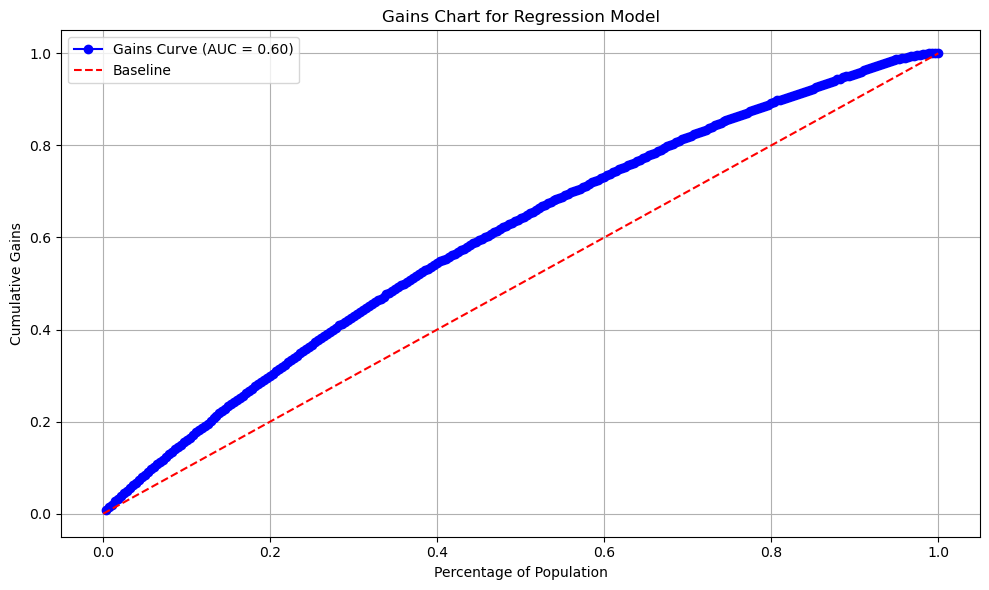

Area Under the Gains Curve (AUC): 0.5990


In [29]:
gains_chart(e_y_train, predict_train)

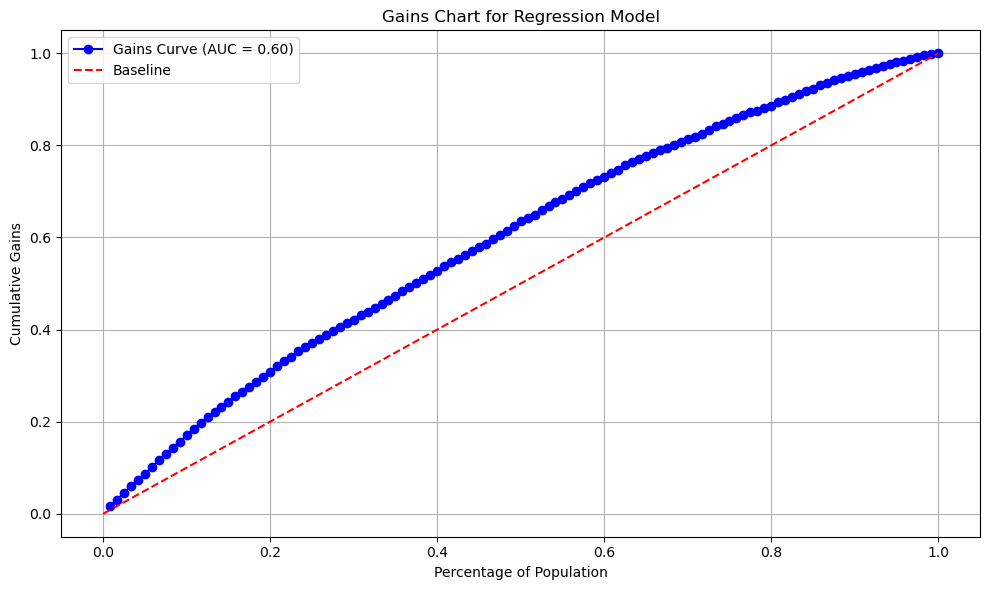

Area Under the Gains Curve (AUC): 0.5966


In [30]:
gains_chart(e_y_test, predict_test)

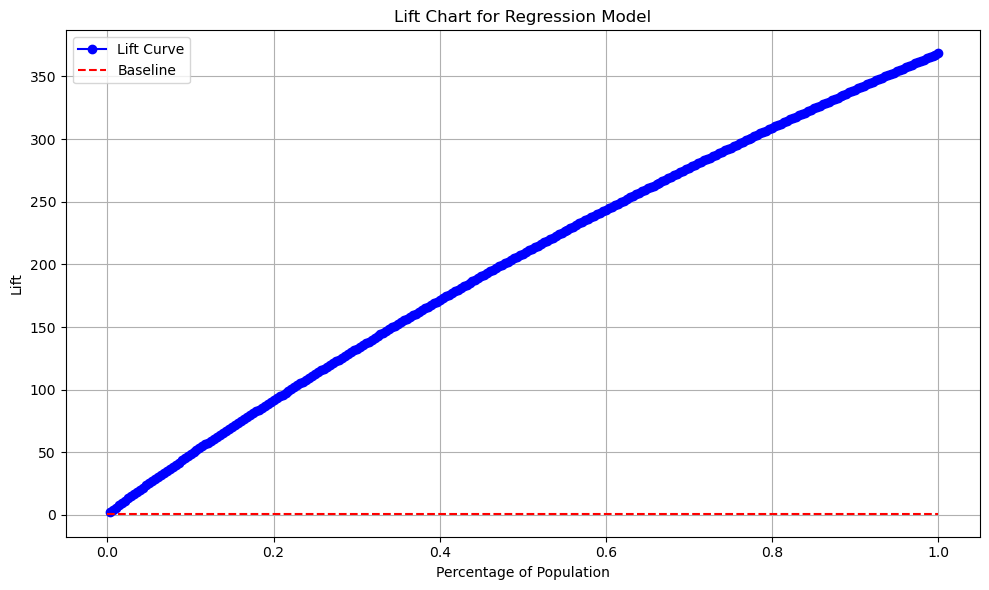

In [31]:
lift_chart_regression(y_train, predict_train)

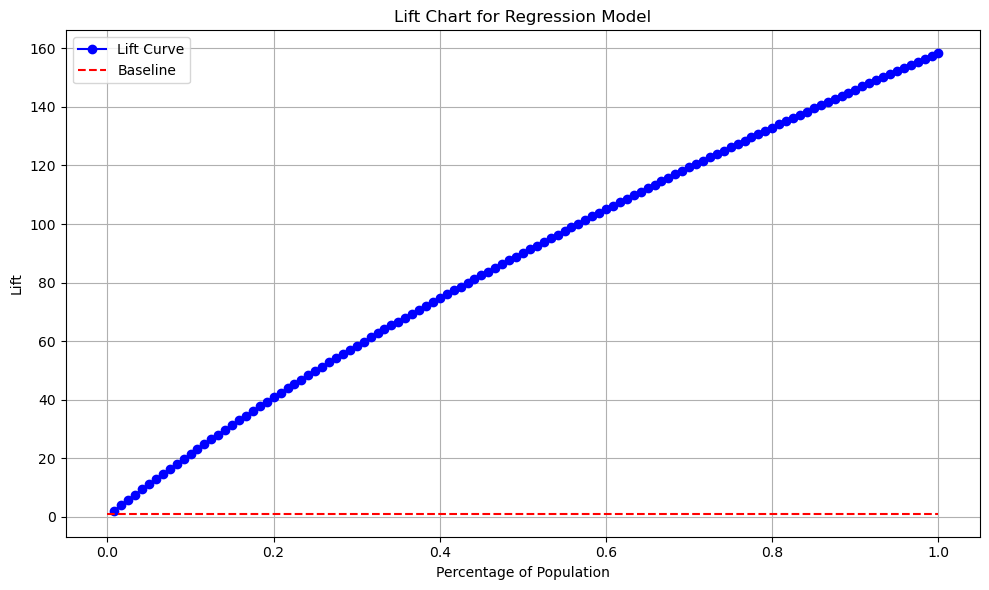

In [32]:
lift_chart_regression(y_test, predict_test)

making Actual vs Predicted graph

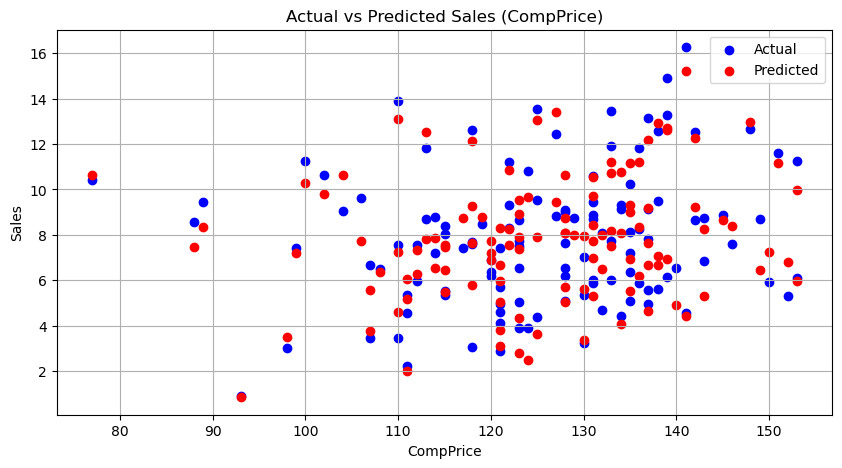

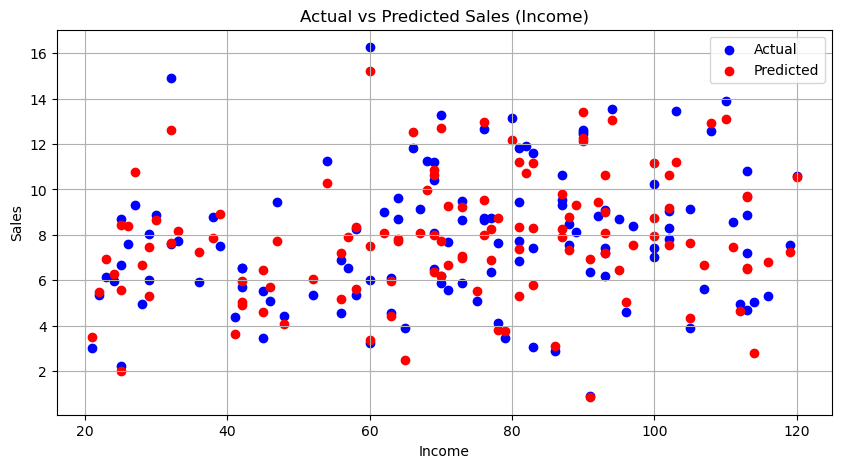

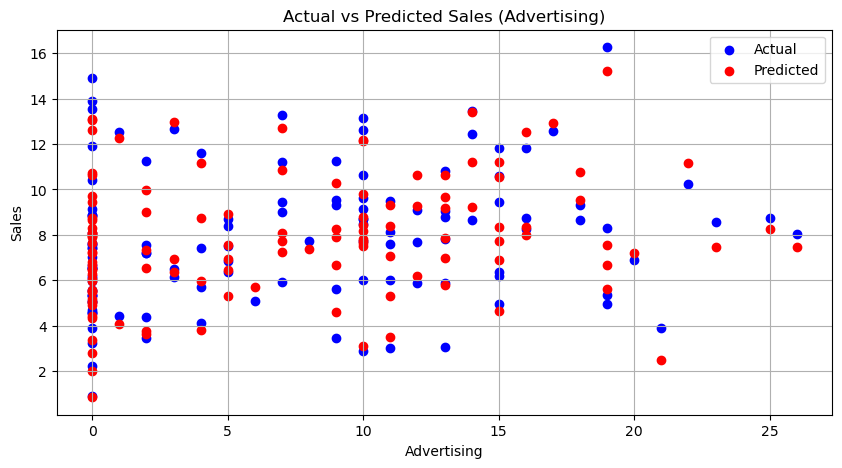

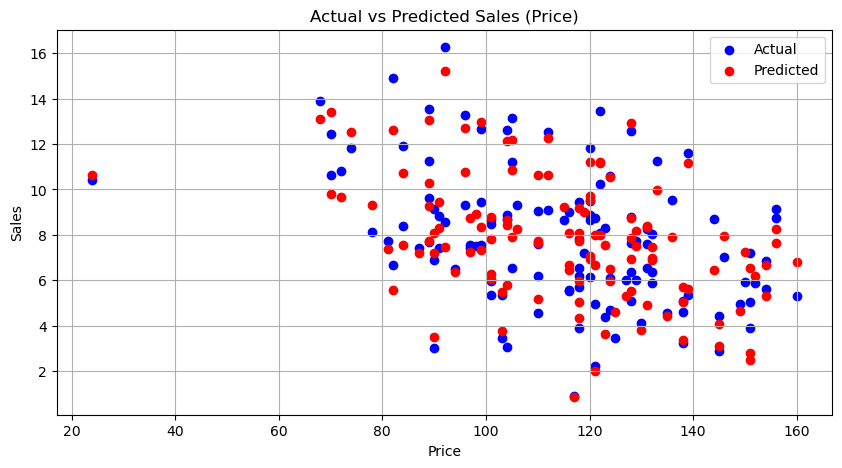

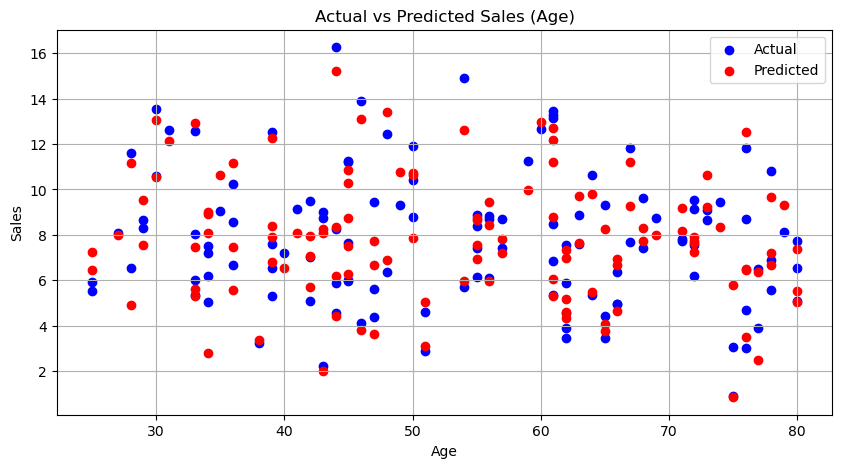

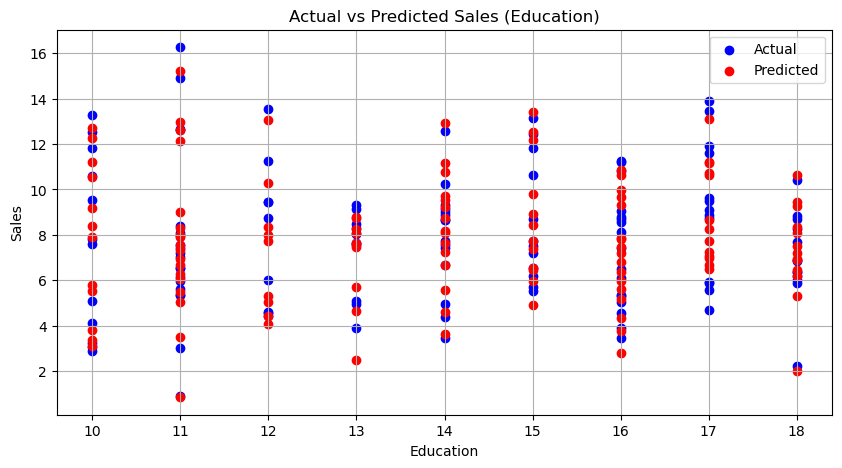

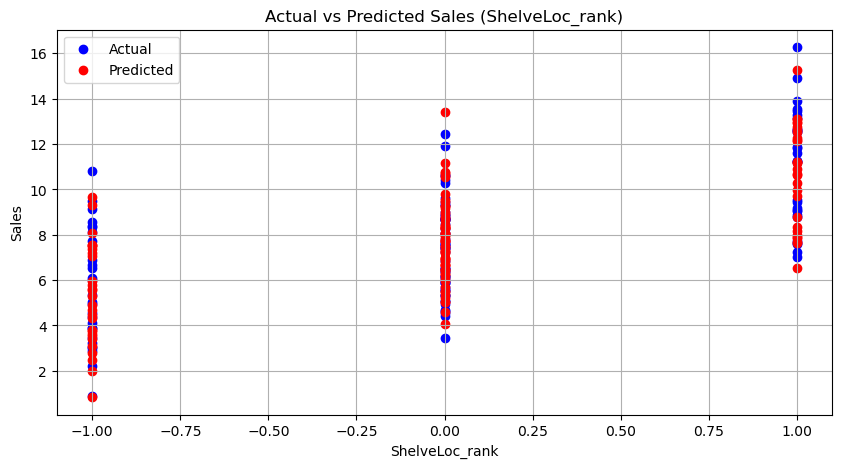

In [66]:
def actualvsprediction(x_list, x_test, y_test, predict_test, y_name, size_x=10, size_y=5, color1='blue', color2='red'):
    # x_list is the list of x values of the model (including 'intercept')
    # x_test is the x values of the test
    # y_test is the y values found when the model was tested
    # predict_test is the y values that the model predicts
    # y_name is the name of the dependent variable
    # size_x, size_y, color1, color2, are details to make the graph

    # iterate through all x values in model EXCEPT intercept
    for i in x_list:

        if i == 'intercept':
            continue
        
        # plot making stuff
        plt.figure(figsize=(size_x, size_y)) 
        plt.scatter(x_test[i], y_test, color=color1, label='Actual')
        plt.scatter(x_test[i], predict_test, color=color2, label='Predicted')
        plt.xlabel(i)
        plt.ylabel(y_name)
        plt.title(f'Actual vs Predicted {y_name} ({i})')
        plt.legend()
        plt.grid(True)
        plt.show() 

x_list = ['intercept', 'CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'Education','ShelveLoc_rank']

actualvsprediction(x_list, x_test, y_test, predict_test, 'Sales')